# Improving the model: Hyperparameter tuning with [Talos](https://autonomio.github.io/docs_talos/#scan)

Good article on hyperparameter optimization with Keras [here](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import LogCosh, BinaryCrossentropy
from tensorflow.keras.activations import relu, elu, sigmoid
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop

import talos
from talos.model.normalizers import lr_normalizer
from talos.utils.load_model import load_model

sns.set()
tf.__version__

Using TensorFlow backend.


'2.0.0'

In [2]:
data = pd.read_csv('dataset/exit_prediction.csv')
data.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# label/features
labels = data.pop('Exited')

# one-hot encoding
features = pd.get_dummies(data)
features.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0


### Train/Test split

We will use 50% of the data for pure testing(validation). The rest 50% we shall split into train/test.

In [3]:
train_features, pure_testing_features, train_labels, pure_testing_labels = train_test_split(features, labels,
                                                                    test_size=0.5, random_state=1, stratify=labels)

# Convert to numpy arrays and standardize
train_labels = train_labels.values
train_features = talos.utils.rescale_meanzero(train_features.values)

### Some useful documentations

1. **Talos**
    - The [Scan](https://autonomio.github.io/docs_talos/#scan) method: All of the options affecting the experiment, except for the hyperparameters, are defined here
    - [lr_optimizers](https://autonomio.github.io/docs_talos/#lr-normalizer): Allows one to define different learning rates for different kinds of optimizers
    - One can utilize 3 kinds of optimization strategies with Talos
        - Grid Search: by default Talos will try out every possible parameter specified. Not recommended ofc.
        - Random Search: use *grid_downsample=0.01* to use 1% of the data for instance.
        - [Probabilistic reduction](https://autonomio.github.io/docs_talos/#probabilistic-reduction): make a stop between the rounds, evaluate the worst performing parameter and then eliminate it from the remaining search space
    
    - Early Stopping: If gotten correctly (which is tricky) can dramatically improve run-time
2. **Keras** Sequential model
    - [Docs](https://keras.io/guides/sequential_model/)
    - Appropriate for a plain stack of layers. A rather straightforward NN
    - Each layer has exactly one input & output tensor
3. Dense Layer
    - [Docs](https://keras.io/api/layers/core_layers/dense/)
    - [Docs](https://keras.io/api/layers/initializers/) on kernel initializers. Define the way to set the initial random weights of Keras layers.
    - [Docs](https://keras.io/api/layers/activations/) on activation functions
4. Dropout Layer
    - [Docs](https://keras.io/api/layers/regularization_layers/dropout/)
5. Loss Functions
    - [Docs](https://keras.io/api/losses/)
6. Optimizers
    - [Docs](https://keras.io/api/optimizers/)
7. compile
    - [Docs](https://keras.io/api/models/model_training_apis/)
8. fit
    - [Docs](https://keras.io/api/models/model_training_apis/)

In [4]:
# Class weights might be handy to use in later hyperparameter optimizations as our classes
# are imbalanced
def get_class_weights(labels):
    counter = Counter(labels)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

get_class_weights(labels)

{1: 3.9091801669121256, 0: 1.0}

## First run of experiment

In [5]:
# Over 1 Million different combinations
params = {
    'layer1_units': list(range(20,100,9)),
    'layer2_units': list(range(20,60,5)),
    'layer3_units': list(range(20,40,3)),
    'optimizer': [Adam, Nadam, RMSprop],
    'lr': [0.1, 0.5, 1, 5],
    # kernel = weights
    'kernel_initializer': ['uniform', 'normal'],
    'use_bias': [True, False],
    'activation1': [relu, elu],
    'activation2': [sigmoid],
    'dropout': list(np.linspace(0, 0.4, 6)),
    # since this is a binary classification task
    'losses': ['binary_crossentropy', 'logcosh'],
    'epochs': list(range(100, 150, 6)),
    'batch_size': list(range(30, 70, 5)),
#     'class_weight': list(get_class_weights(train_labels).values()),
}

for k, v in params.items():
    print(k,":",v)

layer1_units : [20, 29, 38, 47, 56, 65, 74, 83, 92]
layer2_units : [20, 25, 30, 35, 40, 45, 50, 55]
layer3_units : [20, 23, 26, 29, 32, 35, 38]
optimizer : [<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>]
lr : [0.1, 0.5, 1, 5]
kernel_initializer : ['uniform', 'normal']
use_bias : [True, False]
activation1 : [<function relu at 0x000002D2E316E0D8>, <function elu at 0x000002D2E272CA68>]
activation2 : [<function sigmoid at 0x000002D2E316E438>]
dropout : [0.0, 0.08, 0.16, 0.24, 0.32, 0.4]
losses : ['binary_crossentropy', 'logcosh']
epochs : [100, 106, 112, 118, 124, 130, 136, 142, 148]
batch_size : [30, 35, 40, 45, 50, 55, 60, 65]


In [6]:
def customer_exit_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['layer1_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer2_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer3_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['activation2'], kernel_initializer=params['kernel_initializer'], 
                                                                       use_bias=params['use_bias']))
    
    model.compile(loss=params['losses'], 
                  optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])),
                  # For this dataset, using accuracy as a metric is basically ok
                  metrics=['acc', talos.utils.metrics.f1score])

    history = model.fit(x_train, y_train, 
                   validation_data=[x_val, y_val],
                   batch_size=params['batch_size'],
#                    callbacks=[talos.utils.live()],
                   epochs=params['epochs'],
                   verbose=0,
                   shuffle=True,)

    return history, model

In [34]:
# run the experiment
t = talos.Scan(x=train_features,
               y=train_labels,
               val_split=0.25,
               model=customer_exit_model,
               params=params,
               experiment_name='Customer exit prediction',
               fraction_limit = 0.00005,
#                random_method='quantum',
#                reduction_method='corelation',
#                reduction_interval=10,
#                reduction_window=20,
#                reduction_threshold=0.6,
#                reduction_metric='fmeasure',
              )

100%|██████████| 2090/2090 [17:12:01<00:00, 29.63s/it]  


In [7]:
experiment = talos.Reporting('experiments/experiment2.csv')
print('Highest validation accuracy:', round(100*experiment.high('val_acc'),2))
print('Highest validation f1 score:', round(100*experiment.high('val_f1score'), 2))
print('Number of rounds it took to find the best model', experiment.rounds2high('val_acc'))

Highest validation accuracy: 86.24
Highest validation f1 score: 61.4
Number of rounds it took to find the best model 667


In [8]:
experiment = talos.Reporting('experiments/experiment1.csv')
print('Highest validation accuracy:', round(100*experiment.high('val_acc'),2))
print('Highest validation accuracy:', round(100*experiment.high('acc'),2))
print('Highest validation f1 score:', round(100*experiment.high('val_f1score'), 2))
print('Number of rounds it took to find the best model', experiment.rounds2high('val_acc'))

Highest validation accuracy: 88.24
Highest validation accuracy: 98.27
Highest validation f1 score: 61.38
Number of rounds it took to find the best model 917


Next, we can investigate the best parameters for some of the top experiments

In [9]:
experiment.best_params('val_acc', [], ascending=True)

,lr,val_f1score,epochs,loss,dropout,use_bias,losses,activation2,optimizer,round_epochs,kernel_initializer,val_loss,f1score,activation1,batch_size,layer3_units,acc,layer2_units,layer1_units,index_num
1060,5.0,0.476236,148,0.160284,0.40,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.n...,148,normal,1.786015,0.799910,<function relu at 0x00000121C8B0F0D8>,30,29,0.915467,55,29,0
13,5.0,0.468462,118,0.112301,0.32,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.a...,118,uniform,1.321221,0.873441,<function relu at 0x00000121C8B0F0D8>,30,32,0.950667,40,83,1
96,5.0,0.493296,106,0.121244,0.08,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.a...,106,uniform,1.221756,0.872842,<function relu at 0x00000121C8B0F0D8>,65,38,0.951200,30,74,2
1043,5.0,0.520804,112,0.173890,0.00,False,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.a...,112,normal,0.729375,0.809554,<function relu at 0x00000121C8B0F0D8>,60,35,0.924533,25,29,3
1429,5.0,0.494824,100,0.135374,0.16,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.n...,100,uniform,1.391584,0.852417,<function relu at 0x00000121C8B0F0D8>,45,26,0.941600,55,47,4
461,1.0,0.508614,112,0.221874,0.32,False,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.r...,112,normal,0.516192,0.771965,<function relu at 0x00000121C8B0F0D8>,55,35,0.917600,35,83,5
1453,5.0,0.523665,118,0.146209,0.40,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.r...,118,normal,1.289885,0.867873,<function relu at 0x00000121C8B0F0D8>,40,23,0.947200,30,92,6
726,5.0,0.509553,100,0.126491,0.32,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.n...,100,normal,1.161238,0.856518,<function relu at 0x00000121C8B0F0D8>,60,35,0.942933,35,83,7
1309,1.0,0.514481,112,0.116074,0.08,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.n...,112,normal,0.936792,0.873198,<function relu at 0x00000121C8B0F0D8>,60,20,0.949333,45,56,8
1464,5.0,0.529991,148,0.057381,0.00,True,binary_crossentropy,<function sigmoid at 0x00000121C8B0F438>,<class 'tensorflow.python.keras.optimizer_v2.n...,148,uniform,1.541294,0.940708,<function relu at 0x00000121C8B0F0D8>,50,38,0.977867,35,74,9


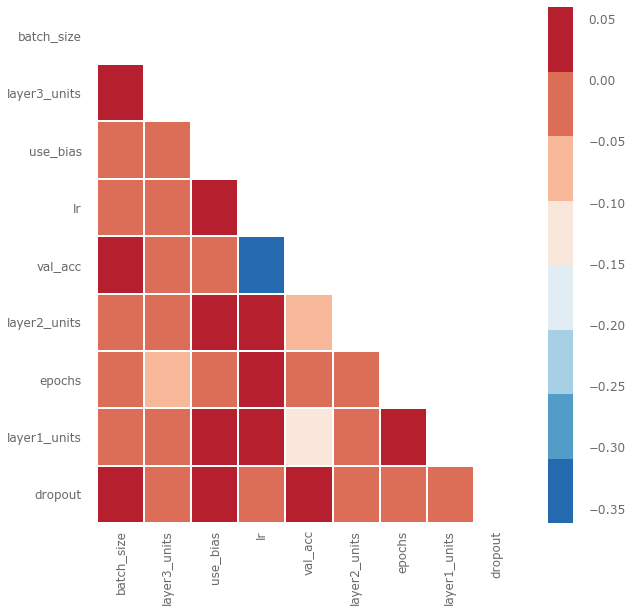

In [10]:
experiment.plot_corr('val_acc', ['f1score', 'val_loss', 'val_f1score', 'acc', 'loss', 'optimizer', 'None', 
                        'activation1', 'activation2', 'kernel_initializer', 'losses', 'index_num', 'round_epochs'])

KDE plots are used to visualize the Probability Density of a continuous variable. It depicts the probability density at different values of a continuous variable.

With a two dimensional KDE plot we can visualize the probability distribution of a sample against multiple continuous attributes.

- For instance, it becomes clear that a lower *lr* will be better for our model.
- We can also lower dropout, though it doesn't seem to make a lot of difference.

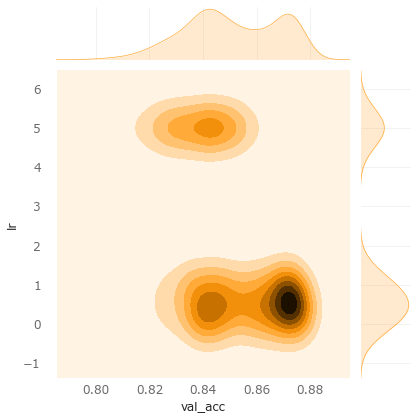

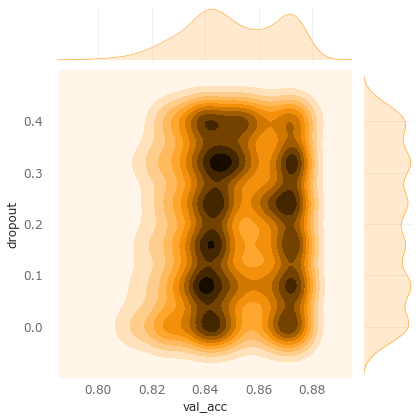

In [11]:
sns.jointplot(experiment.data['val_acc'], experiment.data['lr'], kind='kde', color='#FFAE42'); 
sns.jointplot(experiment.data['val_acc'], experiment.data['dropout'], kind='kde', color='#FFAE42'); plt.show()

- We could also slightly increase the units of *layer 1* & *layer 2*

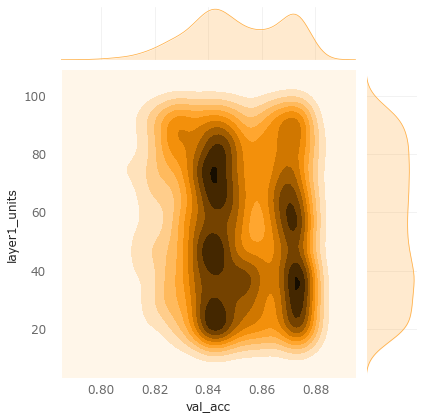

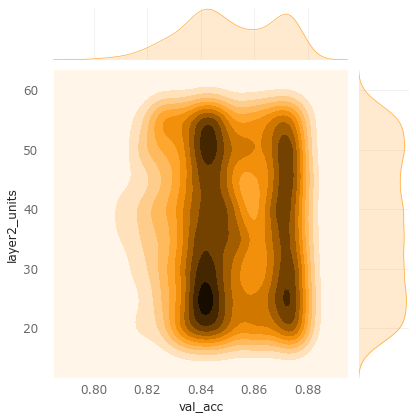

In [13]:
sns.jointplot(experiment.data['val_acc'], experiment.data['layer1_units'], kind='kde', color='#FFAE42')
sns.jointplot(experiment.data['val_acc'], experiment.data['layer2_units'], kind='kde', color='#FFAE42'); plt.show()

## Second run of experiment

After examining the above results we can make appropriate changes to the hyperparameters and do another experiment.

The following parameters, however might not really correspond with the above results as they are the work of many other experiments. You can find all the different experiments (major: *experiment*, minor: *report*) in the report folder.

In [14]:
params2 = {
    'layer1_units': list(range(50,120,5)),
    'layer2_units': list(range(25,50,3)),
    'layer3_units': list(range(25,45,3)),
    'optimizer': [Adam, RMSprop],
    'lr': [0.18, 0.19, 0.2, 0.215, 0.23, 0.25, 0.27],
    'kernel_initializer': ['normal'],
    'use_bias': [True],
    'activation1': ['relu'],
    'activation2': ['sigmoid'],
    'dropout': list(np.linspace(0, 0.3, 6)),
    'losses': ['binary_crossentropy'],
    'epochs': list(range(100, 115, 5)),
    'batch_size': list(range(35, 85, 5)),
}
params2

{'layer1_units': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115],
 'layer2_units': [25, 28, 31, 34, 37, 40, 43, 46, 49],
 'layer3_units': [25, 28, 31, 34, 37, 40, 43],
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam,
  tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop],
 'lr': [0.18, 0.19, 0.2, 0.215, 0.23, 0.25, 0.27],
 'kernel_initializer': ['normal'],
 'use_bias': [True],
 'activation1': ['relu'],
 'activation2': ['sigmoid'],
 'dropout': [0.0, 0.06, 0.12, 0.18, 0.24, 0.3],
 'losses': ['binary_crossentropy'],
 'epochs': [100, 105, 110],
 'batch_size': [35, 40, 45, 50, 55, 60, 65, 70, 75, 80]}

In [15]:
def customer_exit_model2(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['layer1_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer2_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dense(params['layer3_units'], input_dim=x_train.shape[1], activation=params['activation1'],
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['activation2'], kernel_initializer=params['kernel_initializer'], 
                                                                       use_bias=params['use_bias']))
    
    model.compile(loss=params['losses'], 
                  optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])),
                  # For this dataset, using accuracy as a metric is basically ok
                  metrics=['acc', talos.utils.metrics.f1score])

    history = model.fit(x_train, y_train, 
                   validation_data=[x_val, y_val],
                   batch_size=params['batch_size'],
                   epochs=params['epochs'],
                   verbose=0,
                   shuffle=True,)

    return history, model

In [48]:
t = talos.Scan(x=train_features,
               y=train_labels,
               val_split=0.25,
               model=customer_exit_model2,
               params=params2,
               experiment_name='Customer exit prediction',
               fraction_limit = 0.00006,
               random_method='quantum',
               reduction_method='corelation',
              )


100%|██████████| 133/133 [50:37<00:00, 22.84s/it]


reports are simply lighter experiments, in that they run for less epochs.

I did about 19 smaller ones without managing to suprass the *88.24%* accuracy of the first experiment.

In [49]:
PATH = 'experiments/reports/'
val_accs = []
val_f1scores = []
rounds_to_high = []

for filename in os.listdir(PATH):
    report = talos.Reporting(PATH + filename)
    val_accs.append(round(100*report.high('val_acc'), 2))
    val_f1scores.append(round(100*report.high('val_f1score'), 2))
    rounds_to_high.append(report.rounds2high('val_acc'))
    
print('Highest validation accuracy achieved by the lighter experiments:', max(val_accs))
print('Average validation accuracy:', round(np.mean(val_accs), 2), '\n')
print('Highest validation f1 score:', max(val_f1scores))
print('Average validation accuracy:', round(np.mean(val_f1scores), 2), '\n')
print('Average round of experiments to achieve highest accuracy:', round(np.mean(rounds_to_high)))

Highest validation accuracy achieved by the lighter experiments: 87.52
Average validation accuracy: 86.3 

Highest validation f1 score: 64.53
Average validation accuracy: 59.96 

Average round of experiments to achieve highest accuracy: 191.0


In [57]:
report = talos.Reporting(PATH + 'report20.csv')
print(report.high('val_acc'))

0.8752


Highest accuracy model

In [22]:
report = talos.Reporting(PATH + 'report1.csv')
report.best_params('val_acc', [], 10, True)

,lr,val_f1score,epochs,loss,dropout,use_bias,losses,activation2,optimizer,round_epochs,kernel_initializer,val_loss,f1score,activation1,batch_size,layer3_units,acc,layer2_units,layer1_units,index_num
216,0.20,0.347214,100,0.408744,0.125,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.a...,100,normal,0.409253,0.349385,relu,60,29,0.836000,18,20,0
219,0.25,0.464752,116,0.382217,0.125,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,116,normal,0.394937,0.469762,relu,40,23,0.845600,30,23,1
100,0.25,0.451093,108,0.382332,0.500,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.a...,108,normal,0.388464,0.513536,relu,40,26,0.853600,15,32,2
144,0.20,0.442780,108,0.393786,0.375,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.a...,108,normal,0.397105,0.438191,relu,40,26,0.842133,18,20,3
125,0.20,0.457213,104,0.396356,0.375,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.a...,104,normal,0.398905,0.463295,relu,65,26,0.843733,15,23,4
193,0.25,0.428677,108,0.404446,0.375,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,108,normal,0.401886,0.445958,relu,40,23,0.840533,18,20,5
28,0.25,0.500311,124,0.370104,0.250,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,124,normal,0.382498,0.494532,relu,40,23,0.844800,18,29,6
49,0.40,0.452155,124,0.382115,0.250,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,124,normal,0.400970,0.485547,relu,50,29,0.850133,27,26,7
170,0.30,0.436891,116,0.401613,0.500,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,116,normal,0.399380,0.439798,relu,40,23,0.841067,18,23,8
130,0.20,0.452924,112,0.404622,0.500,True,binary_crossentropy,sigmoid,<class 'tensorflow.python.keras.optimizer_v2.r...,112,normal,0.401692,0.429273,relu,65,26,0.839733,24,23,9


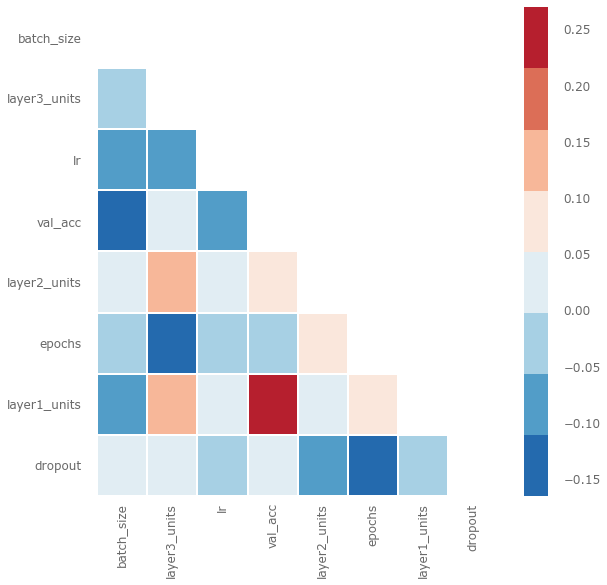

In [23]:
report.plot_corr('val_acc', ['f1score', 'val_loss', 'val_f1score', 'acc', 'loss', 'optimizer', 'None', 
                        'activation1', 'activation2', 'kernel_initializer', 'losses', 'index_num', 'use_bias', 'round_epochs'])

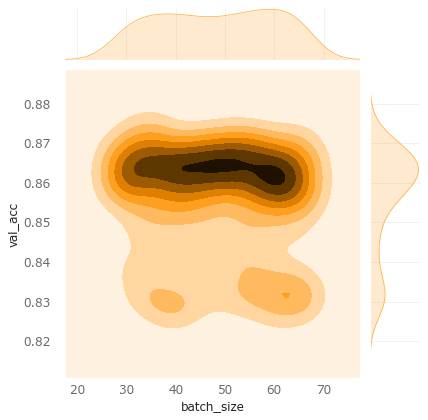

In [24]:
sns.jointplot(report.data['batch_size'], report.data['val_acc'], kind='kde', color='#FFAE42'); plt.show()

## Validation

1. Talos [predict](https://autonomio.github.io/docs_talos/#predict): Used to make predictions on the models that are stored in a *Scan* object
2. Talos [evaluate](https://autonomio.github.io/docs_talos/#evaluate): Evaluate models that are stored on the *Scan* object

In [25]:
# Convert to numpy
pure_testing_features = np.array(pure_testing_features)
pure_testing_labels = np.array(pure_testing_labels)

print(pure_testing_features.shape)
print(pure_testing_labels.shape)

(5000, 13)
(5000,)


### Prediction for the testing set

In [212]:
p = talos.Predict(t)
predictions = p.predict(x=pure_testing_features, metric='val_acc', asc=True)
print('Accuracy on pure testing set:',accuracy_score(pure_testing_labels, predictions))

Accuracy on pure testing set: 0.7962


### Evaluate the testing set

Evaluate based on the f1 score

In [213]:
ev = talos.Evaluate(t)
ev.evaluate(x=pure_testing_features, y=pure_testing_labels, folds=10, metric='val_acc', shuffle=True,
                                                            task='binary', asc=False, print_out=True)

mean : 0.34 
 std : 0.02


[0.3443708609271523,
 0.3739837398373984,
 0.3579638752052545,
 0.3079526226734349,
 0.330550918196995,
 0.33333333333333337,
 0.330550918196995,
 0.3164983164983165,
 0.36065573770491804,
 0.3277591973244147]

## Deploy model

In [214]:
talos.Deploy(t, 'experiment1', 'val_acc', True)

Deploy package experiment1 have been saved.


Model can be loaded (as a Keras sequential model) and we can still do the same predictions

In [33]:
mod = load_model('Deployed/experiment1/experiment1_model')

In [46]:
predictions = mod.predict(pure_testing_features)
predictions = (predictions>0.5)
print(round(100*accuracy_score(pure_testing_labels, predictions), 2))

79.62
